In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import Data and Separate Games

### Notes

End quarter is included as a row of mostly NANs. In column 'desc', this is noted as "END QUARTER ...", i.e. "END QUARTER 1"

In [2]:
def separate_games(df: pd.DataFrame) -> list[pd.DataFrame]:
    """Separate dataframe into separate games via the game ID. Place into a 
    list of games. Indices are reindexed so plays are numbered, starting with 0
    """
    games = [df[df['GameID'] == value].reset_index(drop=True) for value in df['GameID'].unique()]
        
    return games

def separate_years(df: pd.DataFrame) -> list[pd.DataFrame]:
    """Separates the games by which season in which they occured. Outputs a list of seasons."""
    seasons = [df[df['Season'] == value].reset_index(drop=True) for value in df['Season'].unique()]
    
    return seasons

def calculate_time_per_play(game: pd.DataFrame) -> pd.DataFrame:
    """Create a new column which is the time each play took.
    Kicks will have NANs in the new play_time column, which should make them easy to remove
    """
    game['play_time'] = -game['TimeSecs'].diff()

    return game


def drop_unnecessary_rows(game: pd.DataFrame) -> pd.DataFrame:
    """The end of each quarter is its own row. Same with timeouts
    and the end of the game. Other values are mostly NANs.
    This removes all of those unhelpful rows and reindexes

    NOTE: plays must be indexed starting with their first play
    TODO: Might be able to just drop rows with missing posteam
    """
    # find indices
    game.dropna(subset=['posteam', 'play_time'], inplace=True)
    # reset index
    game = game.reset_index(drop=True)

    return game

def encode_teams(game: pd.DataFrame) -> pd.DataFrame:
    """Change all team names to just 0s or 1s. This won't be retraceable if you are
    looking for a game with a specific team playing.
    """
    teams = game['posteam'].unique()
    if len(teams) != 2:
        print(teams)
        raise ValueError("Dataset has not been properly cleaned. There are more than 2 values in posteam.")
    
    team_map = {team:i for i, team in enumerate(teams)}
    game['posteam'] = game['posteam'].map(team_map)
    game['DefensiveTeam'] = game['DefensiveTeam'].map(team_map)

    return game

def create_team0_yardage(game: pd.DataFrame) -> pd.DataFrame:
    """Create a new column which is the yards gained in the play by team zero. 
    It is negative if team 1 is in posession and gains yards.
    """
    game['team0_yards'] = np.where(game['posteam'] == 0, game['Yards.Gained'], -game['Yards.Gained'])

    return game

def no_overtime(game: pd.DataFrame) -> pd.DataFrame:
    """Discard all data on overtime periods. 
    Will result in another Dataframe
    """
    game = game[game["qtr"]!=5]
    return game
    

# Of note: Yards.Gained
# TODO: column of yards gained for team 0, when team 1 gains yards, value is negative
# TODO: keep nans in until you calculate time per play
#   then delete those rows like before and replace nans in time per play with
#   average time per play in that game

### Read in games, separate into individual games

In [3]:
df = pd.read_csv("NFLPlaybyPlay2015.csv")
df.drop(columns=['Unnamed: 0', 'Season'], inplace=True)

games = separate_games(df)

/tmp/ipykernel_4630/2432165581.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("NFLPlaybyPlay2015.csv")


### Clean rows and add columns

In [4]:
for i, game in enumerate(games):
    games[i] = no_overtime(game)
    games[i] = calculate_time_per_play(game)
    games[i] = drop_unnecessary_rows(games[i])
    games[i] = encode_teams(games[i])
    games[i] = create_team0_yardage(games[i])

game = games[30]

print(game['posteam'].unique())

[0 1]


### Take important columns

In [5]:
key_columns = ['team0_yards', 'play_time', 'posteam', 'DefensiveTeam']
               
# TODO: maybe it is easier to calculate team0 yards with 'PosTeamScore'andd'DefTeamScore'.
# We could also choose to always label the team0 as the home team 'posteam', 'DefensiveTeam', 'GameID']
# TODO: check if diff is forward or backward, and decide which one we want

# Check for missing values in these key columns
missing_values = game[key_columns].isnull().sum()
print("Missing values in key columns:\n", missing_values)

Missing values in key columns:
 team0_yards      0
play_time        0
posteam          0
DefensiveTeam    0
dtype: int64


## Train-Test Split
* Respects chronological order, i.e., training set includes games from earlierin the seasons while the test set only later games
* Avoids leakage from future games into the training set
* Even though our focus in on modeling the play-by-play sequences within each game and sequential dependencies are confined to within each game, a time-based split might be better than a random one for the following reasons:
    * If there's evidence that game dynamics change over the season then making sure training games come from an earlier period than test games can better simulate a forecasting scenario
    * Also, in practice, if we're ultimately interested in predicting future plays or games, a time-based split will more closely mimic the conditions under which the model is deployed

In [6]:
# Double check 'Date' is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date and then separate games
df = df.sort_values(by='Date')

# Separate games based on the sorted order
games = separate_games(df)

# Get dates for each game
game_dates = [game.iloc[0]['Date'] for game in games]

# Find the cutoff index: 80% of the games as training
cutoff_index = int(len(games) * 0.8)

# Split games based on sorted order
train_games = games[:cutoff_index]
test_games = games[cutoff_index:]

# Get dates for each game
train_dates = [game.iloc[0]['Date'] for game in train_games]
test_dates = [game.iloc[0]['Date'] for game in test_games]

max_train_date = max(train_dates)
min_test_date = min(test_dates)

print("Training set date range:", min(train_dates), "to", max_train_date)
print("Test set date range:", min_test_date, "to", max(test_dates))

# If the training and test sets share the same boundary date, remove those games from test_games
if max_train_date == min_test_date:
    test_games = [game for game in test_games if game.iloc[0]['Date'] > max_train_date]
    test_dates = [game.iloc[0]['Date'] for game in test_games]
    print("Adjusted Test set date range:", min(test_dates), "to", max(test_dates))

# Final verification: ensure no overlap
assert max(train_dates) < min(test_dates), "There is still an overlap between training and test sets!"

Training set date range: 2015-09-10 00:00:00 to 2015-12-13 00:00:00
Test set date range: 2015-12-13 00:00:00 to 2016-01-03 00:00:00
Adjusted Test set date range: 2015-12-14 00:00:00 to 2016-01-03 00:00:00


In [7]:
train_df = pd.concat(train_games, ignore_index=True)
test_df = pd.concat(test_games, ignore_index=True)
train_df.to_csv("NFLTrain2015.csv", index=False)
test_df.to_csv("NFLTest2015.csv", index=False)

In [8]:
train_df[""]

KeyError: ''

### Alternative data cleaning

In [9]:
df = pd.read_csv("NFL Play by Play 2009-2016 (v3).csv")

#Pick a Home team and index the data on games where they are the home team.

df = df[df["HomeTeam"]=="DET"]

FileNotFoundError: [Errno 2] No such file or directory: 'NFL Play by Play 2009-2016 (v3).csv'

In [10]:
len(df["GameID"].unique())

256

In [11]:
for i, game in enumerate(games):
    games[i] = no_overtime(game)
    games[i] = calculate_time_per_play(game)
    games[i] = drop_unnecessary_rows(games[i])
    games[i] = encode_teams(games[i])
    games[i] = create_team0_yardage(games[i])

game = games[30]

print(game['posteam'].unique())

[0 1]


In [12]:
key_columns = ['team0_yards', 'play_time', 'posteam', 'DefensiveTeam']
               
# TODO: maybe it is easier to calculate team0 yards with 'PosTeamScore'andd'DefTeamScore'.
# We could also choose to always label the team0 as the home team 'posteam', 'DefensiveTeam', 'GameID']
# TODO: check if diff is forward or backward, and decide which one we want

# Check for missing values in these key columns
missing_values = game[key_columns].isnull().sum()
print("Missing values in key columns:\n", missing_values)

Missing values in key columns:
 team0_yards      0
play_time        0
posteam          0
DefensiveTeam    0
dtype: int64


In [13]:
seasons = separate_years(df)
games = separate_games(seasons[0])

KeyError: 'Season'

In [14]:
int(np.floor(2/3 * len(games)))

170

Visualizations

In [25]:
# Double check 'Date' is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date and then separate games
df = df.sort_values(by='Date')

# Separate games based on the sorted order
games = separate_games(df)

# Get dates for each game
game_dates = [game.iloc[0]['Date'] for game in games]

# Find the cutoff index: 80% of the games as training
cutoff_index = int(len(games) * 0.8)

# Split games based on sorted order
train_games = games[:cutoff_index]
test_games = games[cutoff_index:]

# Get dates for each game
train_dates = [game.iloc[0]['Date'] for game in train_games]
test_dates = [game.iloc[0]['Date'] for game in test_games]

max_train_date = max(train_dates)
min_test_date = min(test_dates)

print("Training set date range:", min(train_dates), "to", max_train_date)
print("Test set date range:", min_test_date, "to", max(test_dates))

# If the training and test sets share the same boundary date, remove those games from test_games
if max_train_date == min_test_date:
    test_games = [game for game in test_games if game.iloc[0]['Date'] > max_train_date]
    test_dates = [game.iloc[0]['Date'] for game in test_games]
    print("Adjusted Test set date range:", min(test_dates), "to", max(test_dates))

# Final verification: ensure no overlap
assert max(train_dates) < min(test_dates), "There is still an overlap between training and test sets!"

train_df = pd.concat(train_games, ignore_index=True)
test_df = pd.concat(test_games, ignore_index=True)

Training set date range: 2015-09-10 00:00:00 to 2015-12-13 00:00:00
Test set date range: 2015-12-13 00:00:00 to 2016-01-03 00:00:00
Adjusted Test set date range: 2015-12-14 00:00:00 to 2016-01-03 00:00:00


In [26]:
print(games[0].columns)

Index(['Date', 'GameID', 'Drive', 'qtr', 'down', 'time', 'TimeUnder',
       'TimeSecs', 'PlayTimeDiff', 'SideofField', 'yrdln', 'yrdline100',
       'ydstogo', 'ydsnet', 'GoalToGo', 'FirstDown', 'posteam',
       'DefensiveTeam', 'desc', 'PlayAttempted', 'Yards.Gained', 'sp',
       'Touchdown', 'ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'Safety',
       'PuntResult', 'PlayType', 'Passer', 'PassAttempt', 'PassOutcome',
       'PassLength', 'PassLocation', 'InterceptionThrown', 'Interceptor',
       'Rusher', 'RushAttempt', 'RunLocation', 'RunGap', 'Receiver',
       'Reception', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler1',
       'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'Fumble',
       'RecFumbTeam', 'RecFumbPlayer', 'Sack', 'Challenge.Replay',
       'ChalReplayResult', 'Accepted.Penalty', 'PenalizedTeam', 'PenaltyType',
       'PenalizedPlayer', 'Penalty.Yards', 'PosTeamScore', 'DefTeamScore',
       'ScoreDiff', 'AbsScoreDiff'],
      dtype='object')


In [27]:
print(train_df.columns)


Index(['Date', 'GameID', 'Drive', 'qtr', 'down', 'time', 'TimeUnder',
       'TimeSecs', 'PlayTimeDiff', 'SideofField', 'yrdln', 'yrdline100',
       'ydstogo', 'ydsnet', 'GoalToGo', 'FirstDown', 'posteam',
       'DefensiveTeam', 'desc', 'PlayAttempted', 'Yards.Gained', 'sp',
       'Touchdown', 'ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'Safety',
       'PuntResult', 'PlayType', 'Passer', 'PassAttempt', 'PassOutcome',
       'PassLength', 'PassLocation', 'InterceptionThrown', 'Interceptor',
       'Rusher', 'RushAttempt', 'RunLocation', 'RunGap', 'Receiver',
       'Reception', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler1',
       'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'Fumble',
       'RecFumbTeam', 'RecFumbPlayer', 'Sack', 'Challenge.Replay',
       'ChalReplayResult', 'Accepted.Penalty', 'PenalizedTeam', 'PenaltyType',
       'PenalizedPlayer', 'Penalty.Yards', 'PosTeamScore', 'DefTeamScore',
       'ScoreDiff', 'AbsScoreDiff'],
      dtype='object')


In [28]:
# Distribution of team0_yards
plt.figure(figsize=(5, 4))
plt.hist(train_df['team0_yards'], bins=30, edgecolor='k', alpha=0.75)
plt.xlabel('Team 0 Yards')
plt.ylabel('Frequency')
plt.title('Distribution of Team 0 Yards Gained')
plt.savefig('team0_yards_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'team0_yards'

<Figure size 500x400 with 0 Axes>

In [29]:
# Distribution of play_time
plt.figure(figsize=(5, 4))
plt.hist(train_df['play_time'], bins=30, edgecolor='k', alpha=0.75)
plt.xlabel('Play Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Play Time per Play')
plt.savefig('play_time_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'play_time'

<Figure size 500x400 with 0 Axes>

In [30]:
# Scatter plot of play_time vs. team0_yards
plt.figure(figsize=(5, 4))
plt.scatter(train_df['play_time'], train_df['team0_yards'], alpha=0.75)
plt.xlabel('Play Time (seconds)')
plt.ylabel('Team 0 Yards')
plt.title('Play Time vs. Team 0 Yards')
plt.savefig('play_time_vs_yards.pdf', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'play_time'

<Figure size 500x400 with 0 Axes>

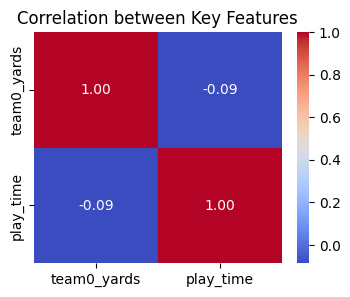

In [ ]:
# Feature Analysis: Correlation heatmap of key columns
key_columns = ['team0_yards', 'play_time']
corr_matrix = games[0][key_columns].corr()

plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Key Features")
plt.savefig("key_features_correlation.pdf", dpi=300, bbox_inches='tight')
plt.show()